# Digit Recognition using Convolutional Neural Networks

Author: Santiago Arambulo

--------------
## Context

This project is part of my portfolio of Data Science and AI projects related to Computer Vision. In this project, I apply Convolutional Neural Networks (CNN) to perform Hand-written Recognition. As the consulting firm BCG illustrates in [this framework]("https://web-assets.bcg.com/95/64/de0162bf44d497bc3d12d5b34284/bcg-robotaxonomy-chart-2023.pdf), CNN is one of the most important technologies for Computer vision and hearing.

--------------
## Data

The data used for this project is the MNIST dataset, which consists of gray-scale 28x28 pixel images of hand-written digits from 0 to 9. This dataset can be dowloaded from Kaggle using the [Kaggle API](https://github.com/Kaggle/kaggle-api) the following command:

`kaggle competitions download -c digit-recognizer`

--------------
## Objective
Given a new image, determine which digit it represents


# Setup
### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

### Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab_Data/'

Mounted at /content/drive/


In [3]:
# path = ''

In [4]:
# Training data
train = pd.read_csv(path + 'train.csv')
y_train = train['label']
X_train = train.drop(['label'], axis=1)
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Testing data
X_test = pd.read_csv(path + 'test.csv')
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have to reshape the data because it has been flatenned. In the received data, each row represents an image, and each row has 784 columns, that represents each pixel in the image. This columns need to be rearrenged as matrixes of dimensions 28x28x1. In this case, there is only one data point for each pixel because the image is represented in gray-scale. This is why the last dimension of the matrix should be 1. However, in other instances, there would be 3 data points for each pixel, representing the corresponding Red, Blue and Green (RGB) color values. In those cases, each row would be associated with a 28x28x3 matrix.

In [6]:
print(f"Original shape for the training data: {X_train.shape}")
print(f"Original shape for the test data: {X_test.shape}")
# Change the dimensions to 3D for each image
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
print(f"Final shape for the training data: {X_train.shape}")
print(f"Final shape for the test data: {X_test.shape}")

Original shape for the training data: (42000, 784)
Original shape for the test data: (28000, 784)
Final shape for the training data: (42000, 28, 28, 1)
Final shape for the test data: (28000, 28, 28, 1)


Also, we need to one-hot encode the labels because they correspond to categorical values and not numeric values

In [7]:
# One-hot encode labels
y_train = to_categorical(y_train)
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

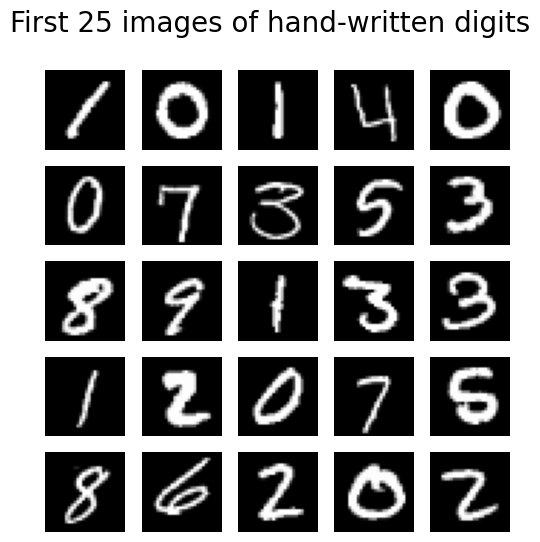

In [15]:
# Show the first 25 images
fig, axs = plt.subplots(5, 5, figsize=(6, 6))
i = 0
for row in axs:
  for ax in row:
    ax.imshow(X_train[i].reshape(28, 28), cmap = 'gray')
    ax.axis('off')
    i += 1
fig.suptitle("First 25 images of hand-written digits", fontsize = 20)
plt.show()

# Models

### Convolutional Neural Network Architecture

#### Convolutional Layers

We will begin with two Convolutional Layers with 16 and 32 filters, and kernel sizes of 3x3. The filters are used to identify features in the image, like edges and shadows in different directions and magnitudes. The first filter is expected to identify more primite features, like horizontal lines, and the second filter, to identify more complex features, like a corner or curve. The kernels are the areas over which we apply the filters. The total number of parameters for the first layer should be:

`kernel_size * num_filters + num_biases = (3 * 3) * 16 + 16 `

We also apply padding to the image, so that the edges of the picture are used in as many operations as the pixels in the center of the image. With padding equal to `same` the image with have a padding of `1` in every direction.

Furthermore, after each Convolutional Layer, we insert an Activation Layer of the type LeakyReLu. Activation Layers provide non-linearity to the model. For example, regular ReLu activation layers transform the input from the previous layer (`x`) to `0` if it is less than `0`, and keep the input the same otherwise. In LeakyReLu layers, the input is transformed to `alpha * x` if `x` is less than `0`, and it is left untouched otherwise.

Finally, before flattening the results from the Convolutional Layers to pass them as inputs to the Dense Layers, we perform a MaxPolling operation. The MaxPool Layers reduces the information passed to the next layer by only keeping the maximum value from a given section of the image. In this case, we will keep the maximum value from each 2x2 section.

#### Dense Layers

We will use two Dense layers, one hidden Dense Layer and the required output Dense Layer. The first layer will have 32 nodes and a LeakyReLu activation function, while the second layer will have 10 nodes (one for each digit) and a softmax activation function. The softmax activation function transforms the results from the current layer to probabilities for each possible outcome. It ensures the output of the model has values from `0-1` and that all values sum up `1`

In [ ]:
models = {}
models['CNN'] = Sequential()
models['CNN'].add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', input_shape=(28, 28, 1)))
models['CNN'].add(LeakyReLU(alpha = 0.1))
models['CNN'].add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
models['CNN'].add(LeakyReLU(alpha = 0.1))
models['CNN'].add(MaxPool2D(pool_size = (2, 2)))
models['CNN'].add(Flatten())
models['CNN'].add(Dense(32))
models['CNN'].add(LeakyReLU(alpha = 0.1))
models['CNN'].add(Dense(10, activation = 'softmax'))
models['CNN'].summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

#### Optimization

We will use the Adam optimizer algorithm to perform the back-propagation and we will use the Categorial Cross Entropy loss function as the optimization target. Additionally, for each epoch, we will report the accuracy of the model (the percentage of correctly identified digits).

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
models['CNN'].compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [ ]:
# Fit the model
epochs = 15
models['CNN_history'] = models['CNN'].fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=32, verbose=1)

Epoch 1/15
1050/1050 [==============================] - 98s 91ms/step - loss: 0.6239 - accuracy: 0.9219 - val_loss: 0.1163 - val_accuracy: 0.9679
Epoch 2/15
1050/1050 [==============================] - 76s 72ms/step - loss: 0.0874 - accuracy: 0.9735 - val_loss: 0.0948 - val_accuracy: 0.9717
Epoch 3/15
1050/1050 [==============================] - 74s 70ms/step - loss: 0.0593 - accuracy: 0.9818 - val_loss: 0.0889 - val_accuracy: 0.9730
Epoch 4/15
1050/1050 [==============================] - 77s 74ms/step - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0958 - val_accuracy: 0.9765
Epoch 5/15
1050/1050 [==============================] - 73s 70ms/step - loss: 0.0411 - accuracy: 0.9877 - val_loss: 0.0978 - val_accuracy: 0.9752
Epoch 6/15
1050/1050 [==============================] - 72s 68ms/step - loss: 0.0427 - accuracy: 0.9879 - val_loss: 0.1016 - val_accuracy: 0.9761
Epoch 7/15
1050/1050 [==============================] - 74s 70ms/step - loss: 0.0346 - accuracy: 0.9897 - val_loss: 0.1180 -

#### Results

In [ ]:
# Plotting the accuracies
epoch_data = models['CNN_history'].history
epoch_data.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

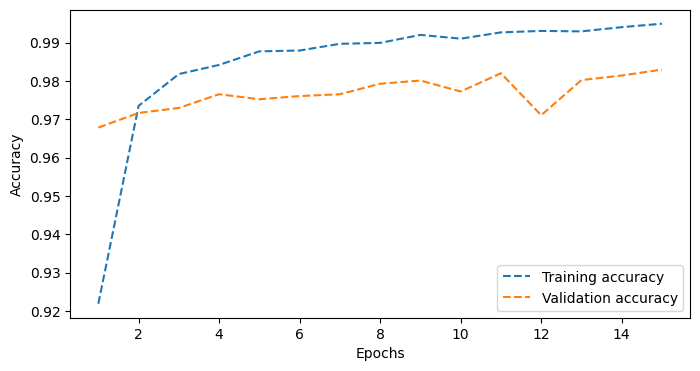

In [ ]:
epoch_nums = np.arange(1, epochs + 1)

plt.figure(figsize = (8,4))
plt.plot(epoch_nums, epoch_data['accuracy'],ls = '--', label = 'Training accuracy')
plt.plot(epoch_nums, epoch_data['val_accuracy'],ls = '--', label = 'Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

We can expect the model to have an accuracy of ~98% when recognising new hand-written digits

In [ ]:
# Predicting the probablity of each label for each image
pred_train = models['CNN'].predict(X_train)
# Choosing the labels with the highest probability
pred_train = np.argmax(pred_train, axis=-1)
pred_train[0:5]

1313/1313 [==============================] - 27s 20ms/step


array([1, 0, 1, 4, 0])

In [ ]:
# Predicting the probablity of each label for each image
pred_test = models['CNN'].predict(X_test)
# Choosing the labels with the highest probability
pred_test = np.argmax(pred_test, axis=-1)
pred_test[0:5]

875/875 [==============================] - 17s 19ms/step


array([2, 0, 9, 9, 3])

In [ ]:
# Recovering labels from one-hot encoded vector
y_train = np.argmax(y_train, axis=-1)
y_train[0:5]

array([1, 0, 1, 4, 0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4132
           1       0.99      1.00      0.99      4684
           2       0.99      1.00      0.99      4177
           3       1.00      1.00      1.00      4351
           4       0.99      0.99      0.99      4072
           5       1.00      0.99      1.00      3795
           6       1.00      1.00      1.00      4137
           7       1.00      0.98      0.99      4401
           8       0.99      1.00      0.99      4063
           9       0.99      0.99      0.99      4188

    accuracy                           0.99     42000
   macro avg       0.99      0.99      0.99     42000
weighted avg       0.99      0.99      0.99     42000



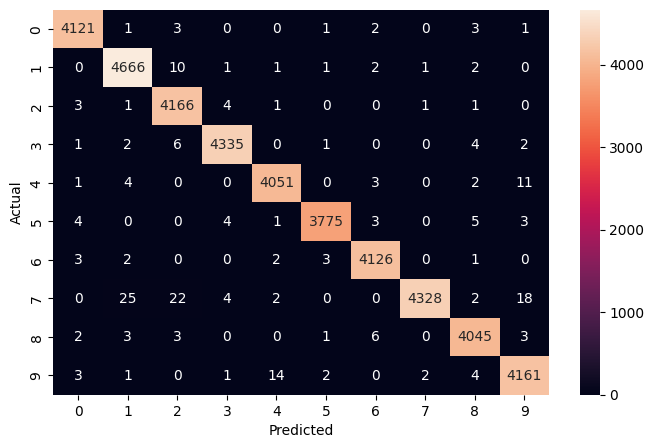

In [ ]:
# Printing the classification report
print(classification_report(y_train, pred_train))

# Plotting the confusion matrix
cm = confusion_matrix(y_train, pred_train)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The model is able to identify all digits with similar accuracy. There is only a slight difficulty recognizing the numbers 8 (confused mainly with 9) and 3 (confused with 2 and 7).

In [ ]:
submission = pd.DataFrame(data = {
    "ImageId": np.arange(1, len(pred_test) + 1),
    "Label": pred_test
}).set_index("ImageId")
submission.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [ ]:
submission.to_csv("submission.csv")